In [6]:
# 1) Load processed (comma-separated, '?' missing)
import pandas as pd

columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach',
           'exang','oldpeak','slope','ca','thal','num']

def read_processed(path, origin):
    df = pd.read_csv(path, header=None, names=columns,
                     sep=',', skipinitialspace=True, na_values=['?'], engine='python')
    df['origin'] = origin
    return df

df_cleveland = read_processed('cleveland.data', 'Cleveland') 
df_hungarian = read_processed('hungary.data', 'Hungary')      
df_switzerland = read_processed('switzerland.data', 'Switzerland')
df_va = read_processed('long_beach_va.data', 'Long Beach VA')

df = pd.concat([df_cleveland, df_hungarian, df_switzerland, df_va], ignore_index=True)

# 2) Binary target from num>0
df['target'] = (df['num'] > 0).astype('int8')

# 3) Dtypes (categoricals as nullable ints; origin as category)
for c in ['sex','cp','fbs','restecg','exang','slope','thal']:
    df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')
df['origin'] = df['origin'].astype('category')

# 4) Quick checks
print(df.shape)                    # expect (920, 16) including origin/target
print(df['origin'].value_counts()) # 303/294/123/200
print(df.isna().sum().sort_values(ascending=False).head(10))
print(df['target'].value_counts())


(920, 16)
origin
Cleveland        303
Hungary          294
Long Beach VA    200
Switzerland      123
Name: count, dtype: int64
ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalach      55
exang        55
chol         30
restecg       2
dtype: int64
target
1    509
0    411
Name: count, dtype: int64


In [7]:
# Overall % missing
miss_overall = (df.isna().mean()*100).round(1).sort_values(ascending=False)
print(miss_overall.head(10))

# % missing by site (origin)
miss_by_origin = (
    df.groupby('origin')
      .apply(lambda g: g.isna().mean()*100)
      .T.round(1)
      .sort_index()
)
print(miss_by_origin.loc[['ca','thal']])  # typical culprits


ca          66.4
thal        52.8
slope       33.6
fbs          9.8
oldpeak      6.7
trestbps     6.4
thalach      6.0
exang        6.0
chol         3.3
restecg      0.2
dtype: float64
origin  Cleveland  Hungary  Long Beach VA  Switzerland
ca            1.3     99.0           99.0         95.9
thal          0.7     90.5           83.0         42.3


<positron-console-cell-7>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<positron-console-cell-7>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


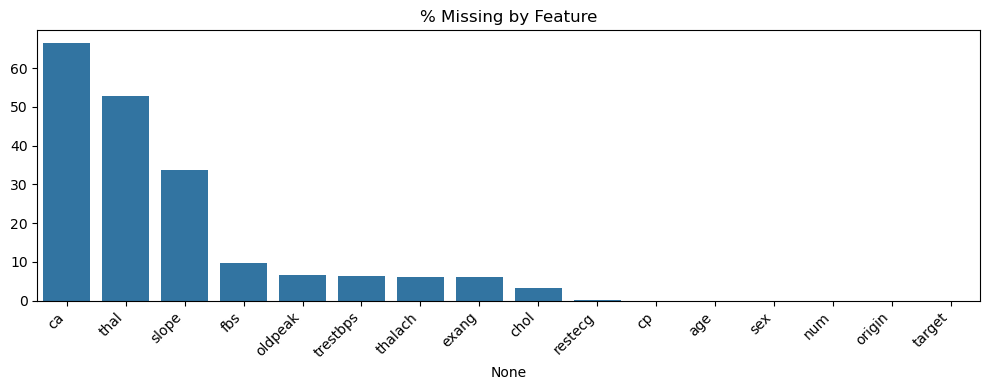

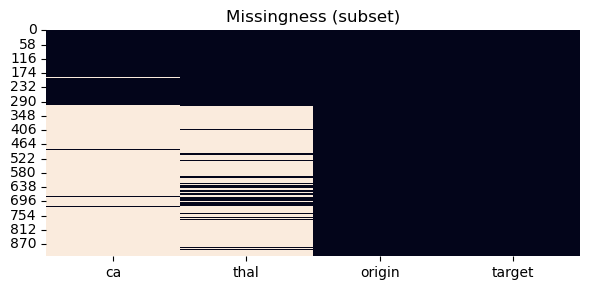

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.barplot(x=miss_overall.index, y=miss_overall.values)
plt.xticks(rotation=45, ha='right'); plt.title('% Missing by Feature'); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
sns.heatmap(df[['ca','thal','origin','target']].isna(), cbar=False)
plt.title('Missingness (subset)'); plt.tight_layout(); plt.show()


In [9]:
# Columns
num_cols = ['age','trestbps','chol','thalach','oldpeak','ca']
cat_cols = ['sex','cp','fbs','restecg','exang','slope','thal','origin']  # treat origin as categorical

# SimpleImputer
from sklearn.impute import SimpleImputer
df_imp_simple = df.copy()
df_imp_simple[num_cols] = SimpleImputer(strategy='median').fit_transform(df_imp_simple[num_cols])
df_imp_simple[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df_imp_simple[cat_cols])

# KNNImputer for numerics (k=5 to start), keep simple impute for categoricals
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[num_cols])
knn = KNNImputer(n_neighbors=5)
num_knn_scaled = knn.fit_transform(num_scaled)
num_knn = scaler.inverse_transform(num_knn_scaled)

df_imp_knn = df.copy()
df_imp_knn[num_cols] = num_knn
df_imp_knn[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df_imp_knn[cat_cols])

# Stability table (key stats under each imputer)
def key_stats(d):
    return {
        'n': len(d),
        'oldpeak_mean': round(d['oldpeak'].mean(), 3),
        'thalach_mean': round(d['thalach'].mean(), 3),
        'ca_mean': round(d['ca'].mean(), 3)
    }

comp = pd.DataFrame({'Simple': key_stats(df_imp_simple),
                     'KNN_k5': key_stats(df_imp_knn)})
print(comp)


ValueError: Cannot cast object dtype to float64

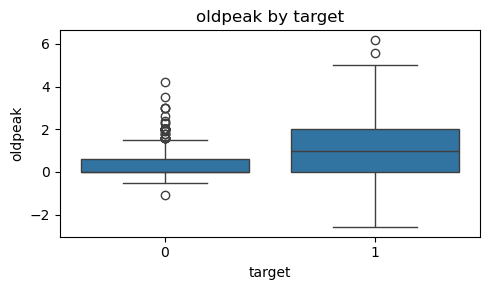

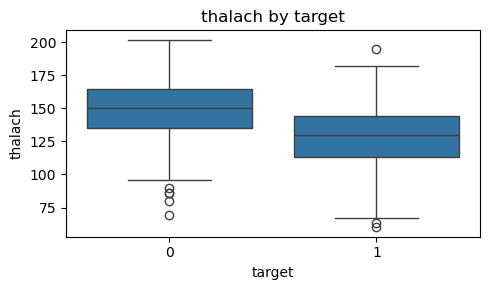

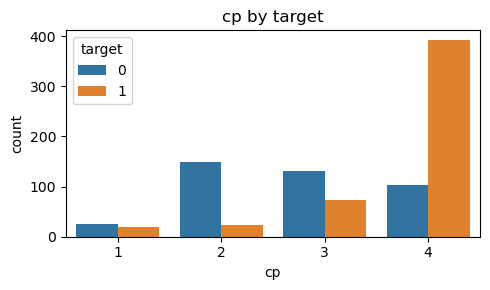

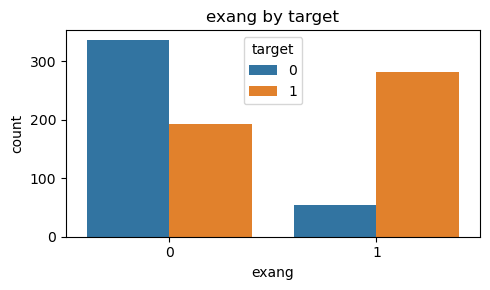

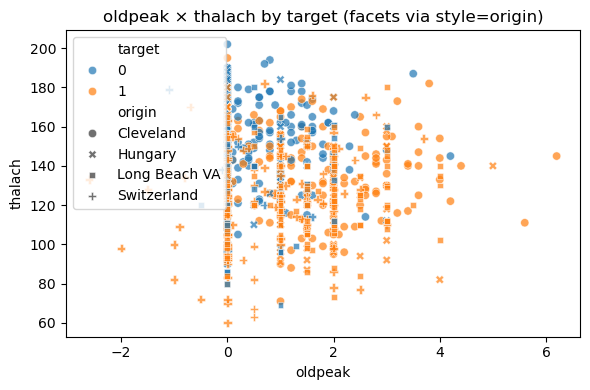

In [10]:
# Outcome-split distributions
plt.figure(figsize=(5,3)); sns.boxplot(data=df_imp_simple, x='target', y='oldpeak'); plt.title('oldpeak by target'); plt.tight_layout(); plt.show()
plt.figure(figsize=(5,3)); sns.boxplot(data=df_imp_simple, x='target', y='thalach'); plt.title('thalach by target'); plt.tight_layout(); plt.show()

# Categorical contrasts
plt.figure(figsize=(5,3)); sns.countplot(data=df, x='cp', hue='target'); plt.title('cp by target'); plt.tight_layout(); plt.show()
plt.figure(figsize=(5,3)); sns.countplot(data=df, x='exang', hue='target'); plt.title('exang by target'); plt.tight_layout(); plt.show()

# Interaction (shows pattern beyond single variables)
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_imp_simple, x='oldpeak', y='thalach', hue='target', style='origin', alpha=0.7)
plt.title('oldpeak × thalach by target (facets via style=origin)'); plt.tight_layout(); plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_cols = num_cols + cat_cols
y = df['target'].astype(int)
X = df_imp_simple[X_cols]  # use imputed copy

pre = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipe = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=1000))])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
pipe.fit(Xtr, ytr)
proba = pipe.predict_proba(Xte)[:,1]
print('AUC:', round(roc_auc_score(yte, proba), 3))


AUC: 0.926


C:\Users\windo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
